<a href="https://colab.research.google.com/github/davidrs/nltk-last-words/blob/master/nltk_last_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro / Goals
This Colab notebook is for exploring NLP libraries NLTK and Gensim.

It uses the Kaggle dataset of Last Statements by death row inmates. [Data set](https://www.kaggle.com/mykhe1097/last-words-of-death-row-inmates#Texas%20Last%20Statement%20-%20CSV.csv)

**Goals of Colab:**
- Use NLTK for preprocessing.
- Try to infer gender based on FirstNames.
- Build a classifier for some categorical fields: Gender, Age etc.

**Technology Used:**
- Pandas, Seaborn, Matplotlib
- NLTK
- Gensim

## Setup Env

In [79]:
!pip install gender_guesser

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from io import StringIO

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import names, stopwords
import gender_guesser.detector as gender

In [81]:
# ntlk.downloads only need to happen once..I think.
nltk.download('stopwords')
nltk.download('punkt') #DRS: added because something complained it was missing.

from nltk.corpus import names, stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load data

Upload the 'last-words.csv' dataset from Kaggle: https://www.kaggle.com/mykhe1097/last-words-of-death-row-inmates#Texas%20Last%20Statement%20-%20CSV.csv 

In [82]:
from google.colab import files

uploaded = files.upload()

FILE_NAME = list(uploaded.keys())[0]
print('Uploaded: {}'.format(FILE_NAME))

Saving last-words.csv to last-words (1).csv
Uploaded: last-words.csv


In [83]:
# Convert uploaded file bytes into a string for pandas.
bytes_data = uploaded[FILE_NAME]
s= bytes_data.decode("utf-8", "replace")
data = StringIO(s) 
df = pd.read_csv(data)

df.head(3)

,Execution,LastName,FirstName,TDCJNumber,Age,Race,CountyOfConviction,AgeWhenReceived,EducationLevel,NativeCounty,PreviousCrime,Codefendants,NumberVictim,WhiteVictim,HispanicVictim,BlackVictim,VictimOther Races,FemaleVictim,MaleVictim,LastStatement
0,545,Cardenas,Ruben,999275,47,Hispanic,Hidalgo,28.0,11.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,"This is my statement: My final words. First, I..."
1,544,Pruett,Robert,999411,38,White,Bee,22.0,8.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,I just want to let everyone in here to know I ...
2,543,Preyor,Taichin,999494,46,Black,Bexar,34.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,"First and foremost I'd like to say, ""Justice h..."


## Pre-process text
- Split LastStatement into words.
- Add some categorical features.
- Add Gender column.

### Basic clean up & features

In [89]:

# Get the guessed gender for each person based on name.
detector = gender.Detector()
df['gender'] = df.apply(lambda x: detector.get_gender(x['FirstName']), axis=1)
df['is_male'] = df['gender'] == 'male'

def bucket_age(x):
  """Constants based on 25, 75% percentiles. """
  if x['Age'] > 44:
    return 'old'
  elif x['Age'] < 34:
    return 'young'
  else:
    return 'middle'
  
df['age_bucket'] = df.apply(bucket_age, axis=1)

def bucket_num_victims(x):
  if x['NumberVictim'] <= 1:
    return 'one'
  else:
    return 'multiple'
  
df['num_victims_bucket'] = df.apply(bucket_num_victims, axis=1)
  

# Turn previous crime into a boolean.
df['PreviousCrime'] = df.apply(lambda x: x['PreviousCrime']==1 , axis=1)


# Clean up the data and split paragraphs into word lists.

# Remove english stop words.
stopwords_en = set(stopwords.words('english'))

def split_words(x):
    word_list = word_tokenize(x['LastStatement'])
    # Remove non alpha words:
    word_list=[word.lower() for word in word_list if word.isalpha()]
    return word_list

df['LastStatement_words'] = df.apply(split_words, axis=1)
df['LastStatement_cleaned'] = df.apply(lambda x: [word for word in x['LastStatement_words'] if word not in stopwords_en], axis=1)
    

# Describe data to check for outliers.
display(df.describe())
display(df.head(3))

,Execution,TDCJNumber,Age,AgeWhenReceived,EducationLevel,NativeCounty,Codefendants,NumberVictim,WhiteVictim,HispanicVictim,BlackVictim,VictimOther Races,FemaleVictim,MaleVictim
count,545.00000,545.000000,545.000000,527.000000,500.000000,516.000000,517.000000,527.000000,424.000000,423.000000,423.000000,423.000000,526.000000,526.000000
mean,273.00000,517422.089908,39.339450,28.426945,10.148000,0.368217,0.736944,1.394687,0.915094,0.255319,0.203310,0.026005,0.678707,0.712928
std,157.47222,499381.226644,8.458398,7.828356,2.076227,0.539757,1.187976,0.799126,0.826487,0.616567,0.628161,0.210585,0.784009,0.692342
min,1.00000,511.000000,24.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,137.00000,808.000000,33.000000,22.000000,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,273.00000,999014.000000,38.000000,27.000000,10.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,409.00000,999246.000000,44.000000,33.000000,12.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,545.00000,999555.000000,67.000000,57.000000,16.000000,6.000000,13.000000,7.000000,5.000000,4.000000,6.000000,3.000000,6.000000,4.000000


,Execution,LastName,FirstName,TDCJNumber,Age,Race,CountyOfConviction,AgeWhenReceived,EducationLevel,NativeCounty,...,FemaleVictim,MaleVictim,LastStatement,gender,is_male,age_bucket,num_victims_bucket,LastStatement_words,LastStatement_cleaned,featuresets
0,545,Cardenas,Ruben,999275,47,Hispanic,Hidalgo,28.0,11.0,1.0,...,1.0,0.0,"This is my statement: My final words. First, I...",male,True,old,one,"[this, is, my, statement, my, final, words, fi...","[statement, final, words, first, want, thank, ...","{'contains(love)': True, 'contains(family)': T..."
1,544,Pruett,Robert,999411,38,White,Bee,22.0,8.0,0.0,...,0.0,1.0,I just want to let everyone in here to know I ...,male,True,middle,one,"[i, just, want, to, let, everyone, in, here, t...","[want, let, everyone, know, love, much, hurt, ...","{'contains(love)': True, 'contains(family)': F..."
2,543,Preyor,Taichin,999494,46,Black,Bexar,34.0,10.0,0.0,...,0.0,1.0,"First and foremost I'd like to say, ""Justice h...",unknown,False,old,one,"[first, and, foremost, i, like, to, say, justi...","[first, foremost, like, say, justice, never, a...","{'contains(love)': True, 'contains(family)': F..."


### Word Frequencies and counts

In [110]:
# Prepare features based on word frequency.
# Create a vocabulary of all the words
all_words_raw = []
for words in df['LastStatement_cleaned'] :
    all_words_raw += words
    
# Construct a list of the X most frequent words in the overall corpus
all_words = nltk.FreqDist(w.lower() for w in all_words_raw)
word_features = [common[0] for common in all_words.most_common(250)]

print('Some most common words: %s' % word_features[:5])

def document_features(document):
  """Create a feature for each 'common word' and whether last statement contains it."""
  document_words = set(document)
  features = {}
  for word in word_features:
      features['contains(%s)' % word] = (word in document_words)
  # TODO: add a feature for number of words in description.
#   if document_words is None:
#     features['length'] = 0
#   else:
#     features['length'] = len(document_words)
  return features

# Generate the feature sets for all people's statements.
df['featuresets'] = df['LastStatement_cleaned'].apply(document_features)


Some most common words: ['love', 'family', 'know', 'thank', 'sorry']


,Execution,TDCJNumber,Age,AgeWhenReceived,EducationLevel,NativeCounty,Codefendants,NumberVictim,WhiteVictim,HispanicVictim,BlackVictim,VictimOther Races,FemaleVictim,MaleVictim
count,545.00000,545.000000,545.000000,527.000000,500.000000,516.000000,517.000000,527.000000,424.000000,423.000000,423.000000,423.000000,526.000000,526.000000
mean,273.00000,517422.089908,39.339450,28.426945,10.148000,0.368217,0.736944,1.394687,0.915094,0.255319,0.203310,0.026005,0.678707,0.712928
std,157.47222,499381.226644,8.458398,7.828356,2.076227,0.539757,1.187976,0.799126,0.826487,0.616567,0.628161,0.210585,0.784009,0.692342
min,1.00000,511.000000,24.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,137.00000,808.000000,33.000000,22.000000,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,273.00000,999014.000000,38.000000,27.000000,10.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,409.00000,999246.000000,44.000000,33.000000,12.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,545.00000,999555.000000,67.000000,57.000000,16.000000,6.000000,13.000000,7.000000,5.000000,4.000000,6.000000,3.000000,6.000000,4.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


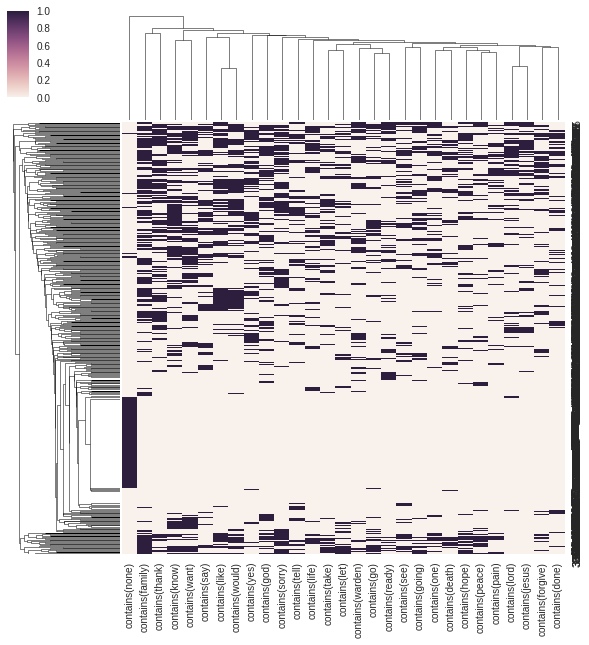

In [113]:
# Cluster map, shows a bunch of people with 'None', ie. didn't have a last statement.
feature_df = pd.DataFrame(df['featuresets'].tolist())

# Reorder columns by most common words.
feature_df = feature_df.reindex_axis(feature_df.mean().sort_values(ascending=False).index, axis=1)

# Cluster map of top N terms.
sns.clustermap(feature_df.iloc[:, 1:30])

## NLTK: Create Classifiers

In [112]:
def create_and_run_classifier(df, target, classifier_type = 'maxent'):
  print('Making a model for target: %s' % target)
  
  # Print counts so we are aware of class imbalance.
  print(df.pivot_table(columns=target, values='FirstName', aggfunc=len))
  
  # Convert DF into Classifier format of tuples of features then label.
  featuresets =[]
  for _, row in df.iterrows():
      featuresets.append((row['featuresets'], row[target]))

  # Shuffle before splitting test/train in case data is ordered in some way.
  random.shuffle(featuresets)

  # Define the train and test sets.
  train_set, test_set = featuresets[100:], featuresets[:100]

  # Train a naive bayes classifier with train set by nltk
  if classifier_type == 'maxent':
    classifier = nltk.MaxentClassifier.train(train_set)
  elif classifier_type == 'naive_bayes':
    classifier = nltk.NaiveBayesClassifier.train(train_set)

  # Get the accuracy of the naive bayes classifier with test set
  print(nltk.classify.accuracy(classifier, test_set))

  # Debug info: show top n most informative features
  classifier.show_most_informative_features(10)
  
create_and_run_classifier(df,'age_bucket')
print('---')
create_and_run_classifier(df,'is_male')
print('---')
create_and_run_classifier(df,'PreviousCrime')
print('---')
create_and_run_classifier(df,'num_victims_bucket')



Making a model for target: age_bucket
age_bucket  middle  old  young
FirstName      255  130    160
  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.285
             2          -1.00298        0.476
             3          -0.99871        0.476
             4          -0.99449        0.476
             5          -0.99032        0.476
             6          -0.98619        0.476
             7          -0.98210        0.476
             8          -0.97807        0.476
             9          -0.97408        0.479
            10          -0.97014        0.479
            11          -0.96624        0.481
            12          -0.96239        0.481
            13          -0.95859        0.488
            14          -0.95483        0.492
            15          -0.95112        0.492
            16          -0.94746        0.494
            17          -0.94384       

### Summary
None of the NaiveBayesClassifier models perform better than the underlying distributions of the categories.
Maxent Classifiers managed to consistantly do marginally better than random.

Some of the relationships make sense: younger people are less likely to talk about their children etc, but since the model performs so poorly this could just be explaining/creative writing for what I'm seeing.

Possible conclusions:
- Need more data. (For gender could try bootstrapping with a larger corpus of text from a different domain with labels.)
- Need better modelling approach.
- There is no relationship between last statements and these categories.

## TODO: Gensim: Find most similar statements